# all converted to MongoDB

In [96]:
from pymongo import MongoClient
from collections import Counter

# Connect to your MongoDB instance
client = MongoClient('mongodb://localhost:27017/')
db = client['vaers']  
collection = db['reports']  

In [97]:
import numpy as np
# Define function to categorize age
def categorize_age(age):
    if pd.isna(age) or age < 0: # Check for NaN or negative values
        return 'Unknown'
    if age < 1/12:  # Neonate: less than 1 month
        return 'Neonate'
    elif age < 2:  # Infant: less than 2 years
        return 'Infant'
    elif age < 12:  # Child: less than 12 years
        return 'Child'
    elif age < 18:  # Adolescent: less than 18 years
        return 'Adolescent'
    elif age < 65:  # Adult: less than 65 years
        return 'Adult'
    else:  # Elderly: 65 years and older
        return 'Elderly'

# Vaccine entries by manufacturer (2020 - 2023)

### all covid vaccines

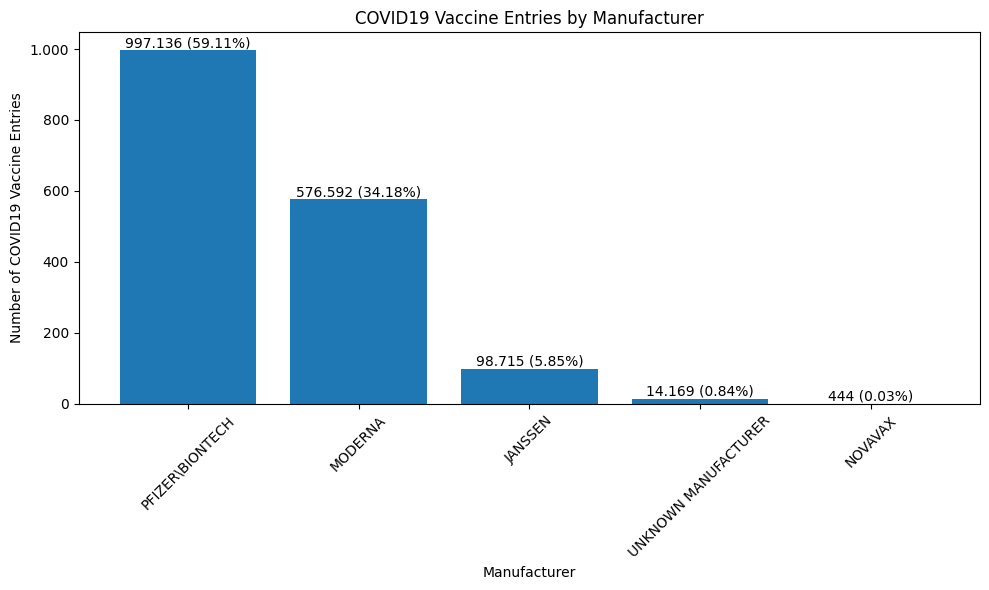

In [98]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker  


# Initialize a dictionary to store counts of COVID19 vaccines by manufacturer
covid_vax_counts = {}

# Define the aggregation pipeline
pipeline = [
    {
        "$match": {"vax_data.VAX_TYPE": {"$regex": "COVID19", "$options": "i"}}
    },
    {
        "$unwind": "$vax_data"
    },
    {
        "$match": {"vax_data.VAX_TYPE": {"$regex": "COVID19", "$options": "i"}}
    },
    {
        "$group": {
            "_id": "$vax_data.VAX_MANU",
            "count": {"$sum": 1}
        }
    }
]

# Execute the aggregation pipeline
results = collection.aggregate(pipeline)

# Count COVID19 vaccine entries by manufacturer
total_entries = 0
for document in results:
    manufacturer = document["_id"]
    count = document["count"]
    covid_vax_counts[manufacturer] = count
    total_entries += count

# Sort the dictionary by counts in decreasing order
sorted_covid_vax_counts = dict(sorted(covid_vax_counts.items(), key=lambda item: item[1], reverse=True))

# Plotting the data
plt.figure(figsize=(10, 6))
bars = plt.bar(sorted_covid_vax_counts.keys(), sorted_covid_vax_counts.values())

plt.xlabel('Manufacturer')
plt.ylabel('Number of COVID19 Vaccine Entries')
plt.title('COVID19 Vaccine Entries by Manufacturer')
plt.xticks(rotation=45)

# Define the custom formatter function for y-axis ticks
def format_with_thousands_sep(x, pos):
    return f'{x/1000:,.0f}'.replace(',', '.')

# Set the formatter for the y-axis
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_with_thousands_sep))
# Annotate each bar with its value and percentage
for bar in bars:
    height = bar.get_height()
    formatted_height = f'{int(height):,}'.replace(',', '.')
    percentage = (height / total_entries) * 100
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{formatted_height} ({percentage:.2f}%)',
             ha='center', va='bottom')

plt.tight_layout()
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Covid_Vaccinations/Entries_by_Manufacturer.png')
plt.show()

# Deaths by manufacturer (2020 - 2023)

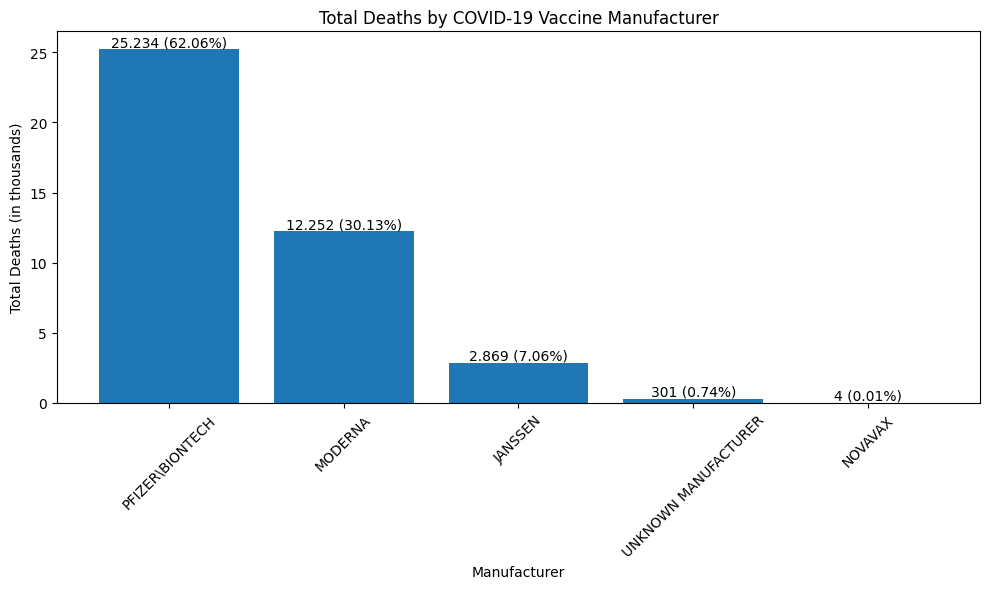

In [99]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Define the aggregation pipeline
pipeline = [
    {
        "$unwind": "$vax_data"  # Unwind the vax_data array
    },
    {
        "$match": {
            "vax_data.VAX_TYPE": {"$regex": "COVID19", "$options": "i"}  # Filter documents with COVID19 vaccine type
        }
    },
    {
        "$project": {
            "VAX_MANU": "$vax_data.VAX_MANU",  # Project the vaccine manufacturer
            "DIED": 1
        }
    },
    {
        "$group": {
            "_id": "$VAX_MANU",
            "deaths": {
                "$sum": {
                    "$cond": [{"$eq": ["$DIED", "Y"]}, 1, 0]  # Count deaths
                }
            }
        }
    }
]

# Execute the aggregation pipeline
results = collection.aggregate(pipeline)

# Aggregate deaths for the same manufacturers
manufacturer_deaths = {}
total_deaths_all = 0
for doc in results:
    manufacturer = doc["_id"]
    deaths = doc["deaths"]
    total_deaths_all += deaths
    manufacturer_deaths[manufacturer] = deaths

# Sort manufacturers by descending deaths
sorted_manufacturer_deaths = dict(sorted(manufacturer_deaths.items(), key=lambda item: item[1], reverse=True))

# Extract data for plotting
manufacturers = list(sorted_manufacturer_deaths.keys())
total_deaths = list(sorted_manufacturer_deaths.values())

# Plotting the data
plt.figure(figsize=(10, 6))
bars = plt.bar(manufacturers, total_deaths)
plt.xlabel('Manufacturer')
plt.ylabel('Total Deaths (in thousands)')
plt.title('Total Deaths by COVID-19 Vaccine Manufacturer')
plt.xticks(rotation=45)
plt.tight_layout()

def thousands_formatter(y, pos):
    return f'{int(y / 1000)}'

formatter = FuncFormatter(thousands_formatter)
plt.gca().yaxis.set_major_formatter(formatter)

# Add numbers and percentages on top of bars
for bar, deaths in zip(bars, total_deaths):
    percentage = (deaths / total_deaths_all) * 100
    formatted_deaths = f'{int(deaths):,}'.replace(',', '.')
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{formatted_deaths} ({percentage:.2f}%)', ha='center', va='bottom')
    
plt.tight_layout()    
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Covid_Vaccinations/Deaths_by_Manufacturer.png')
plt.show()


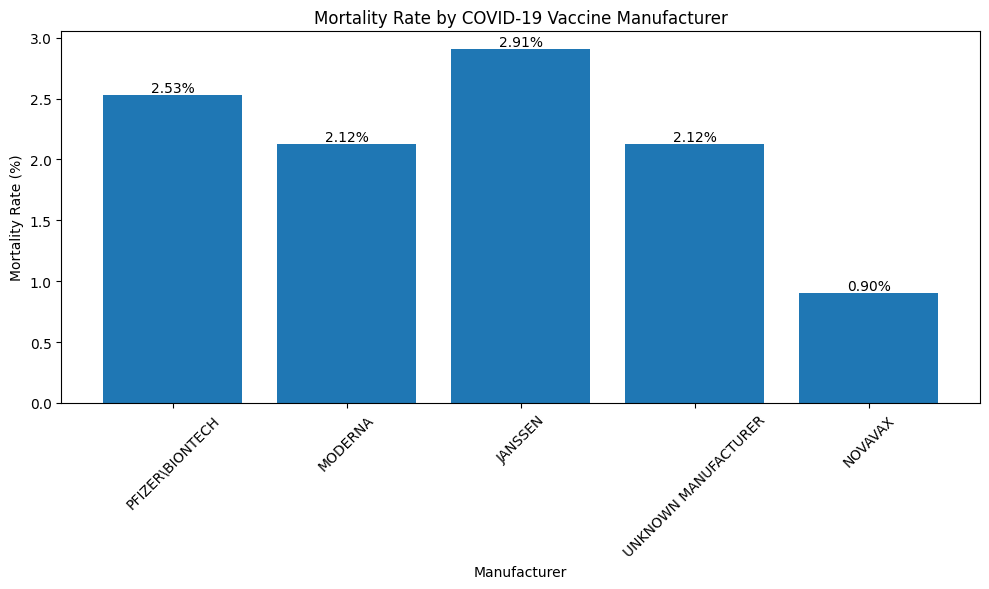

In [100]:
import matplotlib.pyplot as plt

# Define the aggregation pipeline to calculate mortality rate per manufacturer
pipeline_mortality_manufacturer = [
    {
        "$unwind": "$vax_data"  
    },
    {
        "$match": {
            "vax_data.VAX_TYPE": {"$regex": "COVID19", "$options": "i"}  
        }
    },
    {
        "$project": {
            "VAX_MANU": "$vax_data.VAX_MANU",  
            "DIED": 1
        }
    },
    {
        "$group": {
            "_id": "$VAX_MANU",
            "deaths": {
                "$sum": {
                    "$cond": [{"$eq": ["$DIED", "Y"]}, 1, 0]  
                }
            },
            "total_entries": {"$sum": 1}  # Total count of vaccine entries
        }
    }
]

# Execute the aggregation pipeline to calculate mortality rate per manufacturer
results_mortality_manufacturer = collection.aggregate(pipeline_mortality_manufacturer)

# Calculate mortality rate for each manufacturer
mortality_rates_manufacturer = {}
for doc in results_mortality_manufacturer:
    manufacturer = doc["_id"]
    deaths = doc["deaths"]
    total_entries = doc["total_entries"]
    mortality_rates_manufacturer[manufacturer] = (deaths / total_entries) * 100 if total_entries > 0 else 0

# Define the order of manufacturers
order = ['PFIZER\\BIONTECH', 'MODERNA', 'JANSSEN', 'UNKNOWN MANUFACTURER', 'NOVAVAX']

# Sort the mortality rates based on the order
sorted_mortality_rates_manufacturer = {k: mortality_rates_manufacturer[k] for k in order if k in mortality_rates_manufacturer}

# Extract data for plotting
manufacturer_mortality = list(sorted_mortality_rates_manufacturer.keys())
mortality_values_manufacturer = list(sorted_mortality_rates_manufacturer.values())

# Plotting the mortality rate per manufacturer
plt.figure(figsize=(10, 6))
bars_mortality_manufacturer = plt.bar(manufacturer_mortality, mortality_values_manufacturer)
plt.xlabel('Manufacturer')
plt.ylabel('Mortality Rate (%)')
plt.title('Mortality Rate by COVID-19 Vaccine Manufacturer')
plt.xticks(rotation=45)
plt.tight_layout()

# Add numbers on top of bars
for bar, mortality_rate in zip(bars_mortality_manufacturer, mortality_values_manufacturer):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{mortality_rate:.2f}%', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Covid_Vaccinations/Mortality_Rate_by_Manufacturer.png')
plt.show()


# Deaths by vaccine type (mRNA vs Vector) (2020 - 2023)

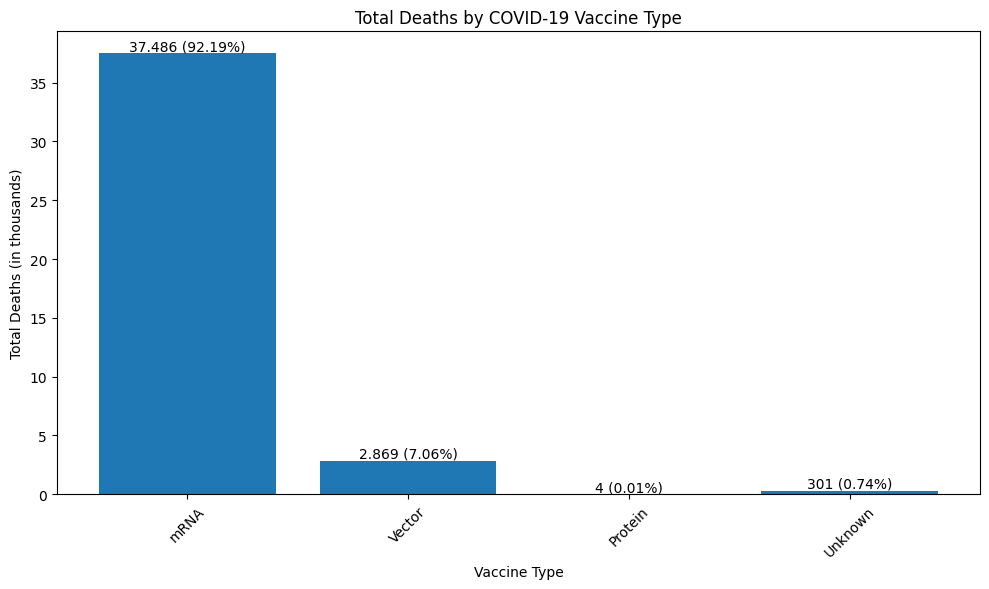

In [101]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Define the aggregation pipeline
pipeline = [
    {
        "$unwind": "$vax_data"  # Unwind the vax_data array
    },
    {
        "$match": {
            "vax_data.VAX_TYPE": {"$regex": "COVID19", "$options": "i"}  # Filter documents with COVID19 vaccine type
        }
    },
    {
        "$project": {
            "VAX_MANU": "$vax_data.VAX_MANU",  # Project the vaccine manufacturer
            "DIED": 1
        }
    },
    {
        "$group": {
            "_id": "$VAX_MANU",
            "deaths": {
                "$sum": {
                    "$cond": [{"$eq": ["$DIED", "Y"]}, 1, 0]  # Count deaths
                }
            }
        }
    },
    {
        "$project": {
            "Vaccine Type": {
                "$switch": {
                    "branches": [
                        {"case": {"$eq": ["$_id", "PFIZER\\BIONTECH"]}, "then": "mRNA"},
                        {"case": {"$eq": ["$_id", "MODERNA"]}, "then": "mRNA"},
                        {"case": {"$eq": ["$_id", "JANSSEN"]}, "then": "Vector"},
                        {"case": {"$eq": ["$_id", "NOVAVAX"]}, "then": "Protein"}
                    ],
                    "default": "Unknown"  # If not matched, set to Unknown
                }
            },
            "Total Deaths": "$deaths",
            "_id": 0
        }
    }
]

# Execute the aggregation pipeline
results = collection.aggregate(pipeline)

# Aggregate deaths for the same vaccine types
vaccine_deaths = {}
total_deaths_all = 0
for doc in results:
    vaccine_type = doc["Vaccine Type"]
    deaths = doc["Total Deaths"]
    total_deaths_all += deaths
    if vaccine_type in vaccine_deaths:
        vaccine_deaths[vaccine_type] += deaths
    else:
        vaccine_deaths[vaccine_type] = deaths

# Define the order of vaccine types
order = ['mRNA', 'Vector', 'Protein', 'Unknown']

# Sort the data based on the order
sorted_vaccine_deaths = {key: vaccine_deaths[key] for key in order if key in vaccine_deaths}

# Extract data for plotting
vaccine_types = list(sorted_vaccine_deaths.keys())
total_deaths = list(sorted_vaccine_deaths.values())

# Plotting the data
plt.figure(figsize=(10, 6))
bars = plt.bar(vaccine_types, total_deaths)
plt.xlabel('Vaccine Type')
plt.ylabel('Total Deaths (in thousands)')
plt.title('Total Deaths by COVID-19 Vaccine Type')
plt.xticks(rotation=45)
plt.tight_layout()

def thousands_formatter(y, pos):
    return f'{int(y / 1000)}'

formatter = FuncFormatter(thousands_formatter)
plt.gca().yaxis.set_major_formatter(formatter)

# Add numbers and percentages on top of bars
for bar, deaths in zip(bars, total_deaths):
    percentage = (deaths / total_deaths_all) * 100
    formatted_deaths = f'{int(deaths):,}'.replace(',', '.')
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{formatted_deaths} ({percentage:.2f}%)', ha='center', va='bottom')
    
plt.tight_layout()    
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Covid_Vaccinations/Deaths_by_Vaccine_Type.png')
plt.show()


# Percentage of deaths by vaccine type (mRNA vs Vector) (2020 - 2023)

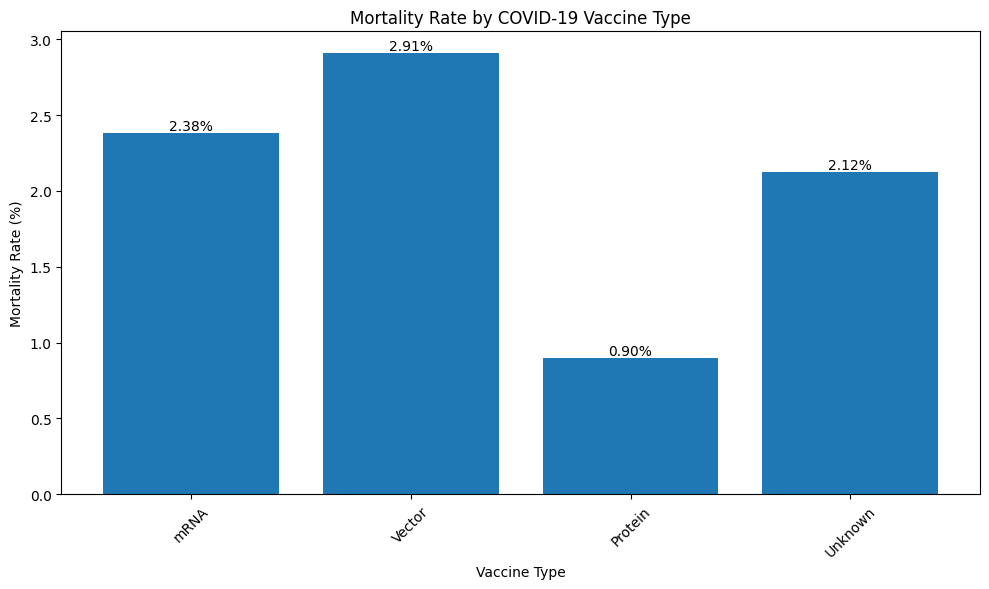

In [102]:
import matplotlib.pyplot as plt

# Define the aggregation pipeline to calculate mortality rate
pipeline_mortality = [
    {
        "$unwind": "$vax_data"  
    },
    {
        "$match": {
            "vax_data.VAX_TYPE": {"$regex": "COVID19", "$options": "i"}  
        }
    },
    {
        "$project": {
            "VAX_MANU": "$vax_data.VAX_MANU",  
            "DIED": 1
        }
    },
    {
        "$group": {
            "_id": {
                "$switch": {
                    "branches": [
                        {"case": {"$in": ["$VAX_MANU", ["PFIZER\\BIONTECH", "MODERNA"]]}, "then": "mRNA"},
                        {"case": {"$eq": ["$VAX_MANU", "JANSSEN"]}, "then": "Vector"},
                        {"case": {"$eq": ["$VAX_MANU", "NOVAVAX"]}, "then": "Protein"},
                    ],
                    "default": "Unknown"
                }
            },
            "deaths": {
                "$sum": {
                    "$cond": [{"$eq": ["$DIED", "Y"]}, 1, 0]  
                }
            },
            "total_entries": {"$sum": 1}  # Total count of vaccine entries
        }
    }
]

# Execute the aggregation pipeline to calculate mortality rate
results_mortality = collection.aggregate(pipeline_mortality)

# Calculate mortality rate for each vaccine type
mortality_rates = {}
for doc in results_mortality:
    vaccine_type = doc["_id"]
    deaths = doc["deaths"]
    total_entries = doc["total_entries"]
    mortality_rates[vaccine_type] = (deaths / total_entries) * 100 if total_entries > 0 else 0

# Define the order of vaccine types
order = {'mRNA': 0, 'Vector': 1, 'Protein': 2, 'Unknown': 3}

# Sort the mortality rates based on the order
sorted_mortality_rates = {key: mortality_rates[key] for key in sorted(mortality_rates, key=lambda x: order.get(x, float('inf')))}

# Extract data for plotting
vaccine_types_mortality = list(sorted_mortality_rates.keys())
mortality_values = list(sorted_mortality_rates.values())

# Plotting the mortality rate
plt.figure(figsize=(10, 6))
bars_mortality = plt.bar(vaccine_types_mortality, mortality_values)
plt.xlabel('Vaccine Type')
plt.ylabel('Mortality Rate (%)')
plt.title('Mortality Rate by COVID-19 Vaccine Type')
plt.xticks(rotation=45)
plt.tight_layout()

# Add numbers on top of bars
for bar, mortality_rate in zip(bars_mortality, mortality_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{mortality_rate:.2f}%', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Covid_Vaccinations/Mortality_Rate_by_Vaccine_Type.png')
plt.show()


# Deaths by age group (2020 - 2023)

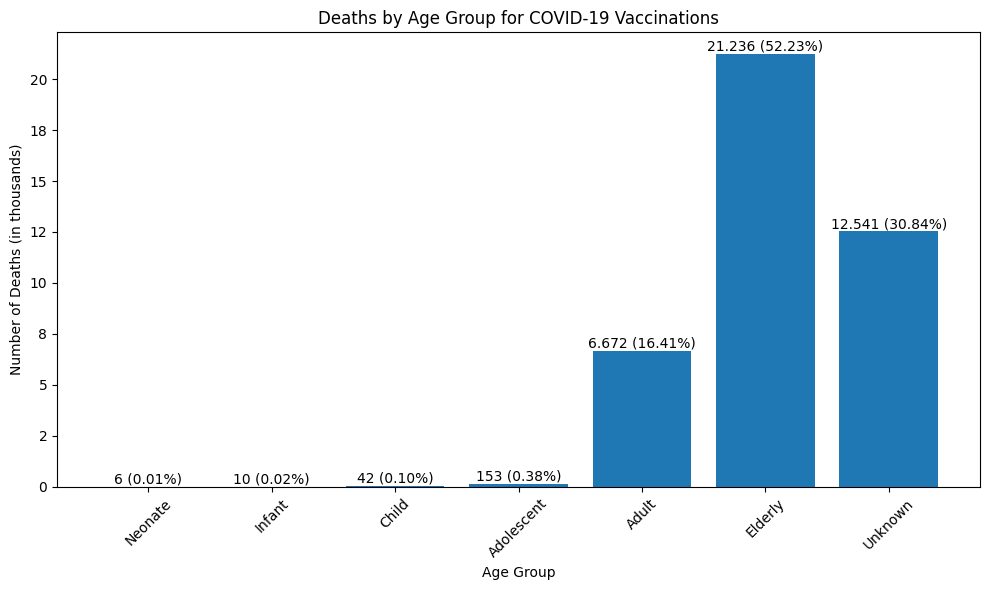

In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Define the aggregation pipeline with age categorization
pipeline = [
    {
        "$unwind": "$vax_data"  # Unwind the vax_data array
    },
    {
        "$match": {
            "vax_data.VAX_TYPE": {"$regex": "COVID19", "$options": "i"}  # Filter documents with COVID19 vaccine type
        }
    },
    {
        "$project": {
            "AGE_GROUP": {
                "$switch": {
                    "branches": [
                        {"case": {"$and": [{"$gte": ["$AGE", 0]}, {"$lt": ["$AGE", 1/12]}]}, "then": "Neonate"},
                        {"case": {"$and": [{"$gte": ["$AGE", 1/12]}, {"$lt": ["$AGE", 2]}]}, "then": "Infant"},
                        {"case": {"$and": [{"$gte": ["$AGE", 2]}, {"$lt": ["$AGE", 12]}]}, "then": "Child"},
                        {"case": {"$and": [{"$gte": ["$AGE", 12]}, {"$lt": ["$AGE", 18]}]}, "then": "Adolescent"},
                        {"case": {"$and": [{"$gte": ["$AGE", 18]}, {"$lt": ["$AGE", 65]}]}, "then": "Adult"},
                        {"case": {"$gte": ["$AGE", 65]}, "then": "Elderly"}
                    ],
                    "default": "Unknown"
                }
            },
            "DIED": 1
        }
    },
    {
        "$group": {
            "_id": "$AGE_GROUP",
            "deaths": {
                "$sum": {
                    "$cond": [{"$eq": ["$DIED", "Y"]}, 1, 0]  # Count deaths
                }
            },
            "total": {"$sum": 1}  # Count total documents for each age group
        }
    }
]

# Execute the aggregation pipeline
results = collection.aggregate(pipeline)

# Initialize a dictionary to store the age group counts for deaths and total documents
age_group_deaths = {
    'Neonate': {'deaths': 0, 'total': 0},
    'Infant': {'deaths': 0, 'total': 0},
    'Child': {'deaths': 0, 'total': 0},
    'Adolescent': {'deaths': 0, 'total': 0},
    'Adult': {'deaths': 0, 'total': 0},
    'Elderly': {'deaths': 0, 'total': 0},
    'Unknown': {'deaths': 0, 'total': 0}
}

# Process the results to populate the age group deaths dictionary
for doc in results:
    age_group = doc["_id"]
    deaths = doc["deaths"]
    total = doc["total"]
    age_group_deaths[age_group]['deaths'] = deaths
    age_group_deaths[age_group]['total'] = total

# Custom formatter to display values in thousands
def thousands_formatter(x, pos):
    return f'{x/1000:.0f}'

total_deaths = sum(val['deaths'] for val in age_group_deaths.values())

# Plotting the data 
plt.figure(figsize=(10, 6))
bars = plt.bar(age_group_deaths.keys(), [val['deaths'] for val in age_group_deaths.values()])
plt.xlabel('Age Group')
plt.ylabel('Number of Deaths (in thousands)')

# Apply the formatter to the y-axis
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(thousands_formatter))

plt.title('Deaths by Age Group for COVID-19 Vaccinations')

# Annotate each bar with the number of deaths and the percentage of deaths
for bar, age_group in zip(bars, age_group_deaths.keys()):
    deaths = age_group_deaths[age_group]['deaths']
    percentage = (deaths / total_deaths) * 100 if total > 0 else 0
    formatted_deaths = f'{deaths:,}'.replace(',', '.')  # Format with a dot for thousands
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{formatted_deaths} ({percentage:.2f}%)',
             ha='center', va='bottom')

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Covid_Vaccinations/Deaths_by_Age_Group.png')
plt.show()


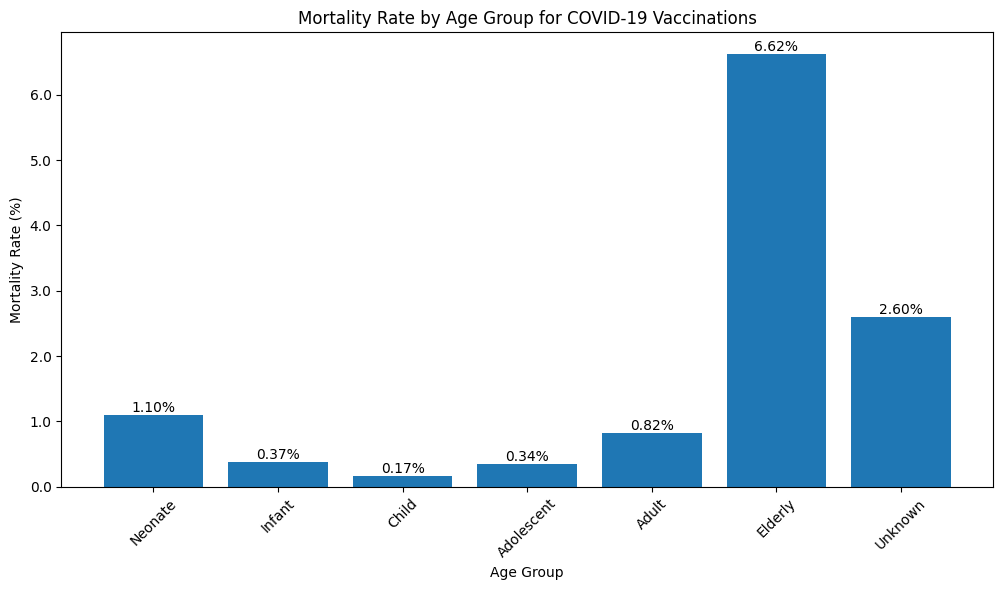

In [104]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Define the aggregation pipeline with age categorization
pipeline = [
    {
        "$unwind": "$vax_data"  # Unwind the vax_data array
    },
    {
        "$match": {
            "vax_data.VAX_TYPE": {"$regex": "COVID19", "$options": "i"}  # Filter documents with COVID19 vaccine type
        }
    },
    {
        "$project": {
            "AGE_GROUP": {
                "$switch": {
                    "branches": [
                        {"case": {"$and": [{"$gte": ["$AGE", 0]}, {"$lt": ["$AGE", 1/12]}]}, "then": "Neonate"},
                        {"case": {"$and": [{"$gte": ["$AGE", 1/12]}, {"$lt": ["$AGE", 2]}]}, "then": "Infant"},
                        {"case": {"$and": [{"$gte": ["$AGE", 2]}, {"$lt": ["$AGE", 12]}]}, "then": "Child"},
                        {"case": {"$and": [{"$gte": ["$AGE", 12]}, {"$lt": ["$AGE", 18]}]}, "then": "Adolescent"},
                        {"case": {"$and": [{"$gte": ["$AGE", 18]}, {"$lt": ["$AGE", 65]}]}, "then": "Adult"},
                        {"case": {"$gte": ["$AGE", 65]}, "then": "Elderly"}
                    ],
                    "default": "Unknown"
                }
            },
            "DIED": 1
        }
    },
    {
        "$group": {
            "_id": "$AGE_GROUP",
            "deaths": {
                "$sum": {
                    "$cond": [{"$eq": ["$DIED", "Y"]}, 1, 0]  # Count deaths
                }
            },
            "total_entries": {"$sum": 1}  # Total count of vaccine entries
        }
    }
]

# Execute the aggregation pipeline
results = collection.aggregate(pipeline)

# Initialize a dictionary to store the age group counts for deaths and total entries
age_group_data = {
    'Neonate': {'deaths': 0, 'total_entries': 0},
    'Infant': {'deaths': 0, 'total_entries': 0},
    'Child': {'deaths': 0, 'total_entries': 0},
    'Adolescent': {'deaths': 0, 'total_entries': 0},
    'Adult': {'deaths': 0, 'total_entries': 0},
    'Elderly': {'deaths': 0, 'total_entries': 0},
    'Unknown': {'deaths': 0, 'total_entries': 0}
}

# Process the results to populate the age group data dictionary
for doc in results:
    age_group = doc["_id"]
    deaths = doc["deaths"]
    total_entries = doc["total_entries"]
    age_group_data[age_group]['deaths'] = deaths
    age_group_data[age_group]['total_entries'] = total_entries

# Plotting the data 
plt.figure(figsize=(10, 6))
bars = plt.bar(age_group_data.keys(), [val['deaths'] / val['total_entries'] * 100 if val['total_entries'] > 0 else 0 for val in age_group_data.values()])
plt.xlabel('Age Group')
plt.ylabel('Mortality Rate (%)')
plt.title('Mortality Rate by Age Group for COVID-19 Vaccinations')

# Annotate each bar with the mortality rate
for bar, age_group in zip(bars, age_group_data.keys()):
    mortality_rate = (age_group_data[age_group]['deaths'] / age_group_data[age_group]['total_entries']) * 100 if age_group_data[age_group]['total_entries'] > 0 else 0
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{mortality_rate:.2f}%',
             ha='center', va='bottom')

plt.xticks(rotation=45)
plt.tight_layout()

plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.1f}'))
plt.savefig('/Users/sep/PycharmProjects/Masterarbeit/Plots/Data_Exploration/Covid_Vaccinations/Mortality_Rate_by_Age_Group.png')
plt.show()


In [105]:
# Initialize a list to store VAERS_IDs of people who died after receiving the NOVAVAX vaccine
novavax_deaths_vaers_ids = []

# Query MongoDB for documents containing NOVAVAX vaccine data and where the person died
query = {
    "vax_data.VAX_MANU": "NOVAVAX",
    "DIED": "Y"
}

projection = {"VAERS_ID": 1}

documents_cursor = collection.find(query, projection)

# Iterate over the documents to extract the VAERS_IDs
for document in documents_cursor:
    vaers_id = document.get("VAERS_ID")
    if vaers_id:
        novavax_deaths_vaers_ids.append(vaers_id)

# Print the VAERS_IDs
print("VAERS IDs for people who died after receiving the NOVAVAX vaccine:")
for vaers_id in novavax_deaths_vaers_ids:
    print(vaers_id)


VAERS IDs for people who died after receiving the NOVAVAX vaccine:
2718399
2726341
2726346
2726501


In [114]:
pipeline = [
    {
        "$unwind": "$vax_data"  # Unwind the vax_data array
    },
    {
        "$match": {
            "vax_data.VAX_TYPE": {"$regex": "COVID19", "$options": "i"}  # Filter documents with COVID19 vaccine type
        }
    }
]

results = collection.aggregate(pipeline)

# Initialize a set to store unique VAERS IDs and a list to store duplicate IDs
unique_vaers_ids = set()
duplicate_vaers_ids = []

# Iterate through the results to check for duplicate VAERS IDs
for doc in results:
    vaers_id = doc.get("VAERS_ID")
    if vaers_id in unique_vaers_ids:
        duplicate_vaers_ids.append(vaers_id)
    else:
        unique_vaers_ids.add(vaers_id)

# Check if there are any duplicate VAERS IDs
if duplicate_vaers_ids:
    print("Duplicate VAERS IDs found:", duplicate_vaers_ids)
else:
    print("No duplicate VAERS IDs found.")

    

Duplicate VAERS IDs found: [905340, 906428, 907159, 907330, 907837, 909370, 909520, 911085, 912442, 912896, 913038, 913869, 914017, 914174, 914458, 915630, 915849, 917087, 919453, 920671, 922571, 922631, 922730, 922731, 923893, 923983, 924830, 925574, 925608, 926240, 926850, 927120, 927265, 927552, 928463, 928604, 928842, 929767, 930686, 977024, 977100, 1279600, 931002, 931015, 931131, 931221, 931336, 931367, 931474, 931533, 931569, 931569, 931622, 931895, 932017, 1377180, 1384983, 932199, 932527, 932800, 932831, 932842, 932850, 932950, 933022, 933054, 933056, 1326313, 933216, 933330, 933540, 933844, 933867, 933878, 933901, 934042, 934042, 934286, 934352, 934402, 934437, 934438, 934521, 934699, 934708, 934743, 935033, 935110, 935155, 935906, 935959, 936486, 936796, 936809, 1399639, 936565, 937102, 937142, 937142, 937219, 937352, 937369, 937422, 937480, 937552, 937670, 938111, 938126, 938132, 938139, 938250, 938302, 938451, 938576, 938633, 938679, 938784, 938929, 938938, 938952, 939041,